
# Meat Net: Implementation
This notebook contains the step to select the best fixed-point datatype to implement the neural network in the FPGA, the second stage training of the models restricting the parameters to be representable in the chosen fixed-point datatype, and the evaluation of the final models.

In [7]:
from math import log, exp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from string import Template
from os import system, mkdir
from sklearn import metrics
import pandas as pd

In [8]:
torch.manual_seed(0);
torch.cuda.manual_seed(0)
np.random.seed(0)

In [9]:
torch.set_num_threads(8)

## Fixed-point datatype selection

To select the fixed-point datatype we are going to use the Vivado HLS implementation of the network and then run different HLS simulatiuons of it using the raw-paramters obtained in the Viertualization network.

The first step is to generate a parameters file to be readable from C++.

In [11]:
D_in, H1, H2, D_out = 11, 32, 12, 1

model = []

class TwoHidden(torch.nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        
        super(TwoHidden, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)
        return x

for i in range(12):
    model.append(TwoHidden(D_in, H1, H2, D_out))

In [12]:
cut_names = ["Inside-Outside", "Round", "Top Sirloin", "Tenderloin", "Flap meat", "Striploin", "Rib eye", "Skirt meat", "Brisket", "Clod Chuck", "Shin", "Fat"]
sens_names = ['MQ135', 'MQ136', 'MQ137', 'MQ138', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ6', 'MQ8', 'MQ9']
params_names = ['w01', 'b01', 'w12', 'b12', 'w23', 'b23']
for i in range(12):
    fout = open("{}/best/params.txt".format(cut_names[i]),"w")
    j=0
    model[i].load_state_dict(torch.load('./{}/best/model.pth'.format(cut_names[i])))
    for name, param in model[i].named_parameters():
        np.savetxt(fout, param.detach().numpy(), fmt='%.6f')
        np.save('{}/best/{}.npy'.format(cut_names[i], params_names[j]), param.detach().numpy())
        j+=1
    fout.close()

The input data is also needed. Also the actual TVC and the predicted by Torch are saved in the same file, for future comparation. 

In [13]:
t = np.load('TestSet/t.npy')
TVC = np.load('TestSet/TVC.npy')
pred_TVC = np.load('TestSet/pred_TVC.npy')
sens_smooth = np.load('TestSet/sens.npy')

In [14]:
t.shape, TVC.shape, pred_TVC.shape, sens_smooth.shape

((444, 12), (444, 12), (444, 12), (444, 11, 12))

In [15]:
for i in range(12):
    np.savetxt('{}/best/test.txt'.format(cut_names[i]), np.column_stack([t[:,i], TVC[:,i], pred_TVC[:,i], sens_smooth[:,:,i]]), header='Time(s) TVC(norm) PredTVC(norm) Smoothed sensor readings (11 channels)')

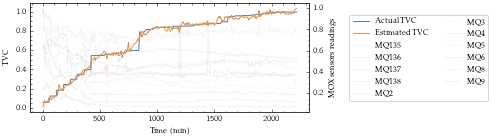

In [16]:
fig, ax2 = plt.subplots(figsize=(15/3, 6/3))

ax1 = ax2.twinx()

ax2.set_ylabel('TVC') 
ax2.plot(t[:,i], TVC[:,i], label='Actual TVC')
ax2.plot(t[:,i], pred_TVC[:,i],label='Estimated TVC')

ax2.set_xlabel('Time (min)')
ax1.set_ylabel('MOX sensors readings')
for j in range(11):
    ax1.plot(t[:,i], sens_smooth[:,j,i], alpha=0.1, label=sens_names[j])
fig.legend(loc='center left', ncol=2,  bbox_to_anchor=(1, 0.5))

plt.savefig('IO-PYestimated-TVC.png', dpi=600)

Now the simulations to test the fixed-point datatypes can be launched.

In [17]:
fixed_candidates = [['16','2'], ['16','3'], ['16','4'], ['14','2'], ['14','3'], ['14','4'], ['12','2'], ['12','3'], ['12','4'], ['10','2'], ['10','3'], ['10','4'], ['8','2'], ['8','3'], ['8','4']]

<div class="alert alert-block alert-warning">
<b>Warning!</b> The next cell must be called from a Vivado HLS-enabled bash, which can be activated using the command:<br>
<code>
source /path/to/Vivado/installation/settings64.sh
</code>
<br>
To use this function inside of a Jupyter notebook like this one, just run this command before launching the Jupyter server.
</div>

In [18]:
for i in range(len(fixed_candidates)):
    # Change the fixed-point datatype parameters in the header file
    with open('MeatNet-h-template.txt') as template:
        h_template = Template(template.read())
    with open('MeatNet.h', 'w') as h:
        h.write(h_template.substitute(W=fixed_candidates[i][0], I=fixed_candidates[i][1]))

    ! vivado_hls fp-sim-launcher.tcl

/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada
/bin/bash: vivado_hls: orden no encontrada


Finally, to select which is the best fixed-point candidate, the results for each candidate in each of the cuts are ploted, computing their MSE (Mean Square Error) compared to the actual TVC.

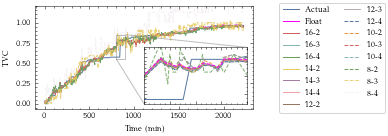

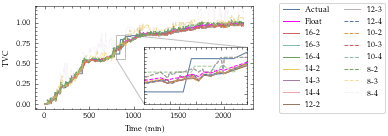

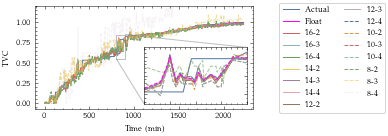

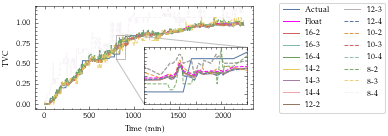

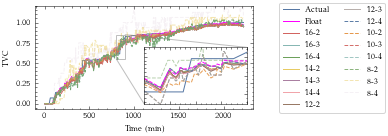

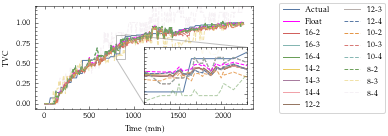

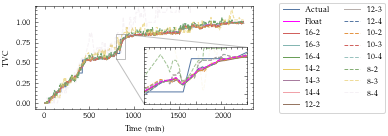

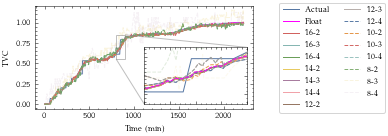

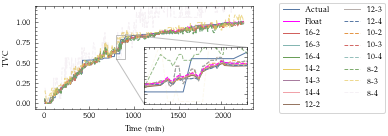

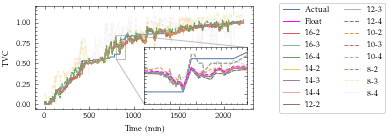

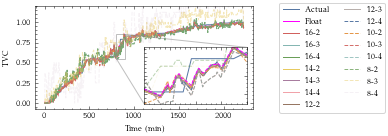

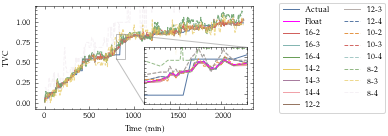

In [19]:
HLSdataTypes = ['{}-{}'.format(W,I) for W, I in fixed_candidates]

HLSpredTVC = np.empty((444,len(HLSdataTypes),12))

errPypredTVC = np.empty(12)
errHLSpredTVC = np.empty((len(HLSdataTypes),12))

for i in range(12):
    for j in range(0, len(HLSdataTypes)):
        HLSpredTVC[:,j,i]= np.loadtxt('{}/fixed-point-selection/{}.txt'.format(cut_names[i], HLSdataTypes[j]), skiprows=1, unpack=True, usecols=3)
        errHLSpredTVC[j,i] = F.mse_loss(torch.tensor(HLSpredTVC[:,j,i]), torch.tensor(TVC[:,i]))
    errPypredTVC[i] = F.mse_loss(torch.tensor(pred_TVC[:,i]), torch.tensor(TVC[:,i]))

    fig, ax = plt.subplots(figsize=(17/3, 6/3))

    ax.plot(t[:,i], TVC[:,i], label='Actual')
    ax.plot(t[:,i], pred_TVC[:,i], color='fuchsia', label='Float')
    for j in range(len(HLSdataTypes)):
        A0 = (1-0.1)/(log(errHLSpredTVC[:,i].min())-log(errHLSpredTVC[:,i].max()))
        k = exp(1/A0)/errHLSpredTVC[:,i].min()
        alpha = A0*log(k*errHLSpredTVC[j,i])
        ax.plot(t[:,i], HLSpredTVC[:,j,i], alpha=alpha, label=HLSdataTypes[j])
    ax.set_ylim(top=1.2)
    

    # inset axes....
    axins = ax.inset_axes([0.5, 0.05, 0.47, 0.55])
    axins.plot(t[:,i], TVC[:,i])
    for j in range(len(HLSdataTypes)):
        A0 = (1-0.1)/(log(errHLSpredTVC[:,i].min())-log(errHLSpredTVC[:,i].max()))
        k = exp(1/A0)/errHLSpredTVC[:,i].min()
        alpha = A0*log(k*errHLSpredTVC[j,i])
        axins.plot(t[:,i], HLSpredTVC[:,j,i], alpha=alpha)
    axins.plot(t[:,i], pred_TVC[:,i], color='fuchsia')
    # sub region of the original image
    x1, x2, y1, y2 = 800, 900, 0.55, 0.85
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')

    ax.indicate_inset_zoom(axins, label='')

    plt.xlabel('Time (min)')
    plt.ylabel('TVC')

    plt.legend(loc='center left', bbox_to_anchor=(1.1, .5), ncol=2)

    plt.tight_layout()

    plt.savefig('{}/fixed-point-selection/comparation-plot.png'.format(cut_names[i]), dpi=600)

The candidates with more bits are expected to have less error, so to select which is the candidate that mets the best balance in the number of bits and the error, we used the Mean error-Bits product which is the product of the average of the MSE metrics of the candidate along the 12 cuts and its total number of bits.

Datatype     Error      Error*bits
------------------------------
16-2 | 0.00128726 | 0.02059621
16-3 | 0.00128723 | 0.02059567
16-4 | 0.00128769 | 0.02060311
14-2 | 0.00128769 | 0.01802772
14-3 | 0.00128970 | 0.01805578
14-4 | 0.00129573 | 0.01814016
12-2 | 0.00129573 | 0.01554871
12-3 | 0.00129911 | 0.01558928
12-4 | 0.00134571 | 0.01614853
10-2 | 0.00134571 | 0.01345711
10-3 | 0.00157580 | 0.01575798
10-4 | 0.00225642 | 0.02256420
8-2  | 0.00225642 | 0.01805136
8-3  | 0.00623810 | 0.04990484
8-4  | 0.04359079 | 0.34872635
------------------------------
Pyth | 0.00120026 | 0.07681676


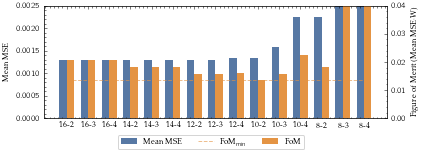

In [26]:
MeanerrHLSpredTVC = np.empty(len(HLSdataTypes))
BitMeanerrHLSpredTVC = np.empty(len(HLSdataTypes))

print('Datatype     Error      Error*bits')
print('------------------------------')
for j in range(len(HLSdataTypes)):
    MeanerrHLSpredTVC[j] = errHLSpredTVC[j,:].mean()
    BitMeanerrHLSpredTVC[j] = errHLSpredTVC[j,:].mean()*float(fixed_candidates[j][0])
    print('{:4s} | {:10.8f} | {:10.8f}'.format(HLSdataTypes[j], MeanerrHLSpredTVC[j], BitMeanerrHLSpredTVC[j]))
print('------------------------------')
print('{:4s} | {:10.8f} | {:10.8f}'.format('Pyth', errPypredTVC.mean(), errPypredTVC.mean()*64.0))

x = np.arange(len(HLSdataTypes))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18/3, 6/3))

ax2 = ax.twinx()
rects1 = ax.bar(x - width/2, MeanerrHLSpredTVC, width, label='Mean MSE')
rects2 = ax2.bar(x + width/2, BitMeanerrHLSpredTVC, width, color = 'C1', label='FoM')

ax2.plot([x[0], x[-1]], [BitMeanerrHLSpredTVC.min(), BitMeanerrHLSpredTVC.min()], 'C1--', alpha=0.6, label='FoM$_{\min}$')

ax.set_ylim(top=0.0025)
ax2.set_ylim(top=0.04)

ax.set_ylabel('Mean MSE')
ax2.set_ylabel('Figure-of-merit (Mean MSE·W)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(HLSdataTypes)
fig.legend(loc="upper center", ncol=3, bbox_to_anchor=(.5, .05))

fig.tight_layout()

plt.savefig('fixed-point-comp-global.png', dpi=600)


## Model retrianing
In order to make the wrights fully representable in the selected fixed-point datatype, `(10,2)` and thus reduce the error in the output, the models are going to retrained starting from the ones obtained in the beginning, but contraining the parameters to be representable in the selected datatype.

The first step is to define a quantizing function.


In [15]:
def ToFixedTensor(TensorOrig, NbitsTot, NbitsInt):
    """
    Esta función cuantiza el dato original a los datos represntables por
    un punto fijo de NbitsTot bits de ancho total y NbitsInt de ancho en
    el entero. Emula el método de HLS usando overflow AP_SAT y cuanti-
    zación AP_RND
    """
    if len(TensorOrig.size())==2:
        rows, cols = TensorOrig.size()

        FixedTensor = torch.empty_like(TensorOrig)

        NbitsFrac = NbitsTot - NbitsInt

        for i in range(rows):
            for j in range(cols):
                #Devolvemos el punto fijo
                FixedTensor[i,j] =  ToFixed(TensorOrig[i,j].item(), NbitsTot, NbitsInt)
    
    elif len(TensorOrig.size())==1:
        cols = TensorOrig.size()[0]

        FixedTensor = torch.empty_like(TensorOrig)

        NbitsFrac = NbitsTot - NbitsInt

        for i in range(cols):

            #Devolvemos el punto fijo
            FixedTensor[i] =  ToFixed(TensorOrig[i].item(), NbitsTot, NbitsInt)
    else: raise ValueError('Tensor de dimensión superior a dos')
    return FixedTensor

def ToFixed(Orig, NbitsTot, NbitsInt):
    """
    Esta función cuantiza el dato original a los datos represntables por
    un punto fijo de NbitsTot bits de ancho total y NbitsInt de ancho en
    el entero. Emula el método de HLS usando overflow AP_SAT y cuanti-
    zación AP_RND
    """
    
    NbitsFrac = NbitsTot - NbitsInt
    
    Int = round(Orig*(2**NbitsFrac))

    if Int > 2**(NbitsTot - 1) - 1:
        Int = 2**(NbitsTot - 1) - 1
    if Int < -2**(NbitsTot - 1):
        Int = -2**(NbitsTot - 1)
    
    #Devolvemos el punto fijo
    return Int*(2**(-NbitsFrac))

Then the retraiing process can be started using this function to quantize the parameters.

In [16]:
for cut in cut_names:
    try:
        mkdir('{}/quant'.format(cut))
    except FileExistsError:
        pass

In [17]:
epochs = 10

In [18]:
quantmodel = model

In [19]:
sens_TS = np.load('TrainSet/sens.npy')
TVC_TS = np.load('TrainSet/TVC.npy')

sens_CrossVS = np.load('ValidSet/sens.npy')
TVC_CrossVS = np.load('ValidSet/TVC.npy')

In [20]:
sens_TS = torch.tensor(sens_TS, dtype=torch.float)
TVC_TS = torch.tensor(TVC_TS, dtype=torch.float)

sens_CrossVS = torch.tensor(sens_CrossVS, dtype=torch.float)
TVC_CrossVS = torch.tensor(TVC_CrossVS, dtype=torch.float)

In [21]:
bsTS = 1
bsVS = 1

train_ds = []
valid_ds = []
train_dl = []
valid_dl = []

for i in range(len(cut_names)):
    train_ds.append(torch.utils.data.TensorDataset(sens_TS[:,:,i], TVC_TS[:,i]))
    valid_ds.append(torch.utils.data.TensorDataset(sens_CrossVS[:,:,i], TVC_CrossVS[:,i]))

    train_dl.append(torch.utils.data.DataLoader(train_ds[i], batch_size=bsTS, shuffle=True))
    valid_dl.append(torch.utils.data.DataLoader(valid_ds[i], batch_size=bsVS))

'Cut: 12/12 Epoch: 10; Train Loss: 0.00066, Min Train Loss: 0.00066; Valid Loss: 0.00065, Min Valid Loss: 0.00065'

Tiempo de entrenamiento: 2.8938090125719707 min


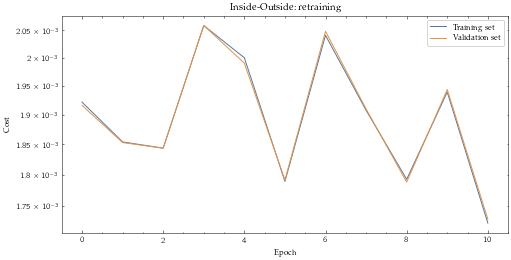

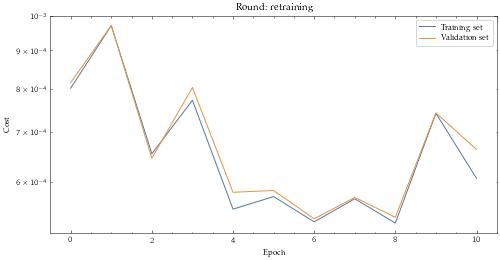

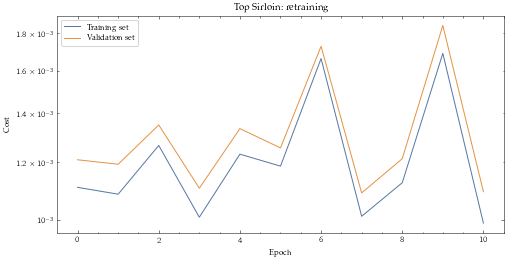

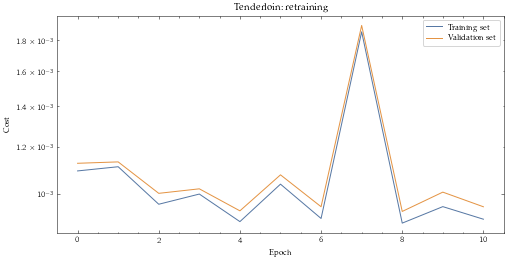

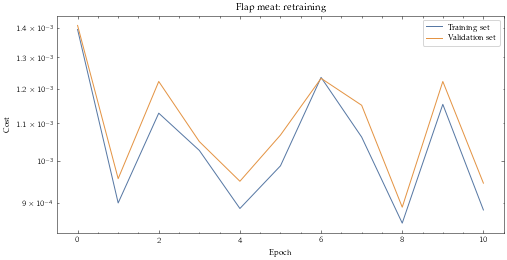

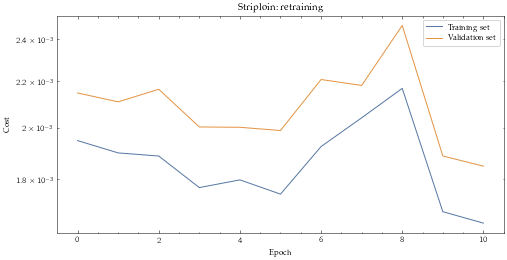

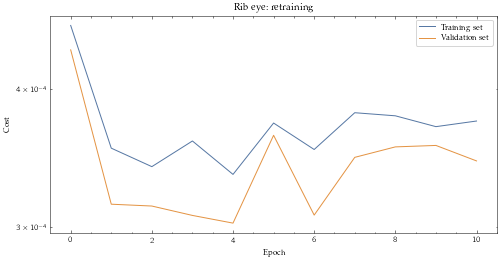

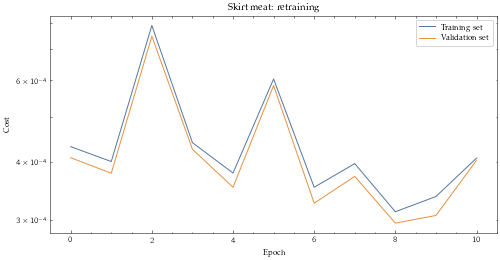

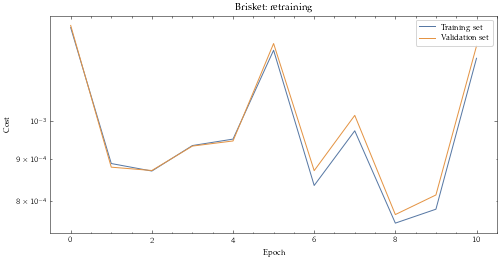

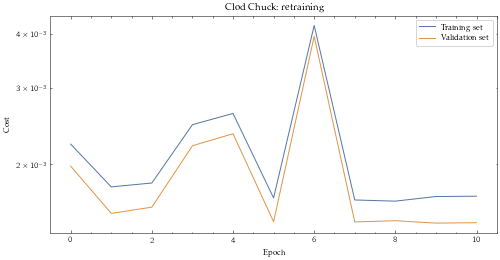

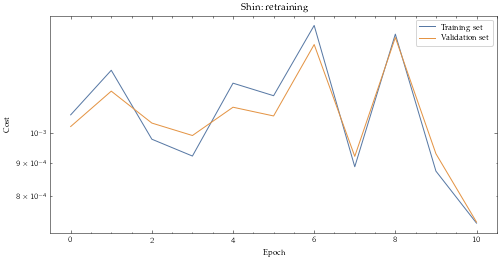

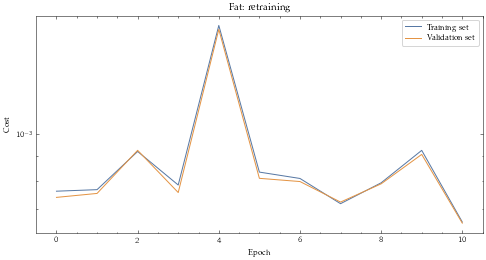

In [22]:
t0 = time.time()

for i in range(12):
    criterion = torch.nn.MSELoss(reduction='mean')
    #criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(quantmodel[i].parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(quantmodel[i].parameters(), lr=3e-4)

    train_loss_data =[]
    train_dl_len = len(train_dl[i])
    valid_loss_data =[]
    valid_dl_len = len(valid_dl[i])
    #valid_loss = 1
    epoch = 0
    #while valid_loss > 1e-3:
    for epoch in range(epochs+1):
        quantmodel[i].train()
        for xb, yb in train_dl[i]:
            pred = quantmodel[i](xb)
            loss = criterion(pred, yb)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        quantmodel[i].eval()
        with torch.no_grad():
            train_loss = sum(criterion(quantmodel[i](xb), yb) for xb, yb in train_dl[i])/train_dl_len
            train_loss_data.append(train_loss)
            valid_loss = sum(criterion(quantmodel[i](xb), yb) for xb, yb in valid_dl[i])/valid_dl_len
            valid_loss_data.append(valid_loss)
            
            if epoch%1==0:
                clear_output(wait=True)
                display('Cut: {}/12 Epoch: {}; Train Loss: {:07.5f}, Min Train Loss: {:07.5f}; Valid Loss: {:07.5f}, Min Valid Loss: {:07.5f}'.format(i+1, epoch, train_loss, min(train_loss_data), valid_loss, min(valid_loss_data)))
            #epoch +=1
            
            if epoch % 1 == 0: #Every epoch the paramteres are quantized:
                for param in quantmodel[i].parameters():
                    param.data = ToFixedTensor(param.data, 10, 2)
            
    plt.figure(figsize=(8,4))
    plt.semilogy(np.arange(epochs+1), train_loss_data, label='Training set')
    plt.semilogy(np.arange(epochs+1), valid_loss_data, label= 'Validation set')
    plt.title('{}: retraining'.format(cut_names[i]))
    plt.ylabel('Cost')
    plt.xlabel('Epoch');
    plt.legend()

    plt.savefig('./{}/quant/retrian-ev.png'.format(cut_names[i]), dpi=600)
    torch.save(quantmodel[i].state_dict(), './{}/quant/VL{:07.5f}.pth'.format(cut_names[i], valid_loss.numpy())) 
    

print('Retraining time: {} min'.format((time.time()-t0)/60))

## Evaluation of the retrained model

In the next cells, the results of the retrained models are evaluated.

In [23]:
pred_TVC_retrain = np.empty_like(pred_TVC)

for i in range(12):
    with torch.no_grad():
        pred_TVC_retrain[:,i] = quantmodel[i](torch.tensor(sens_smooth[:,:,i], dtype=torch.float)).squeeze()


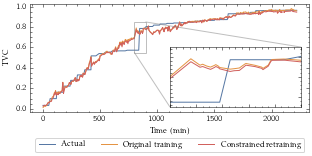

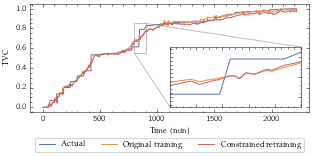

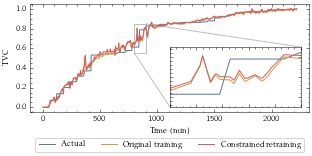

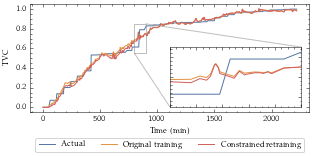

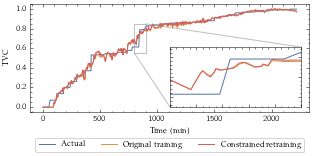

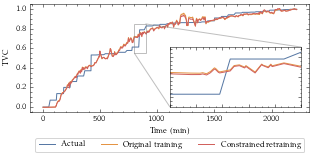

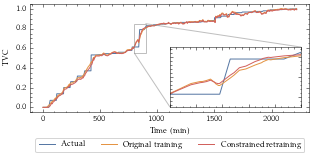

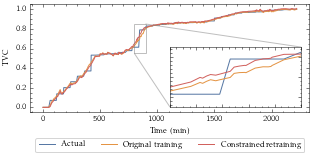

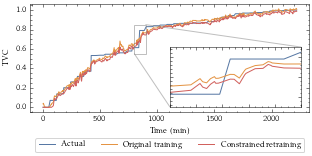

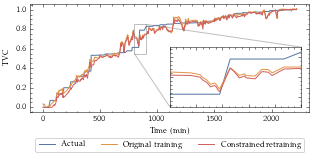

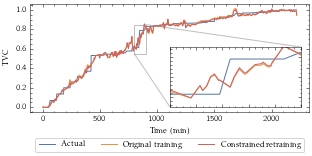

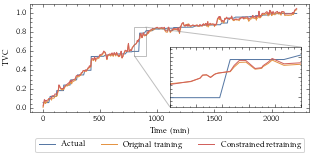

In [24]:
for i in range(12):

    fig, ax = plt.subplots(figsize=(15/3, 6/3))

    ax.plot(t[:, i], TVC[:, i], label='Actual')
    ax.plot(t[:, i], pred_TVC[:, i], label='Original training')
    ax.plot(t[:, i], pred_TVC_retrain[:, i], label='Constrained retraining')

    # inset axes....
    axins = ax.inset_axes([0.5, 0.05, 0.47, 0.55])
    axins.plot(t[:, i], TVC[:, i])
    axins.plot(t[:, i], pred_TVC[:, i])
    axins.plot(t[:, i], pred_TVC_retrain[:, i])
    # sub region of the original image
    x1, x2, y1, y2 = 800, 900, 0.55, 0.85
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')

    ax.indicate_inset_zoom(axins, label='')

    ax.set_ylabel('TVC')
    ax.set_xlabel('Time (min)')

    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.2), ncol=3)

    plt.savefig('{}/quant/retrain-TVC.png'.format(cut_names[i]))

In [25]:
metrics.mean_squared_error(TVC, pred_TVC, multioutput='raw_values')

array([0.00225493, 0.0007515 , 0.00135672, 0.001176  , 0.001042  ,
       0.0022209 , 0.00043326, 0.00041842, 0.00095223, 0.00201492,
       0.00090557, 0.00087669])

In [26]:
metrics.mean_squared_error(TVC, pred_TVC_retrain, multioutput='raw_values')

array([0.00207195, 0.00085423, 0.00141884, 0.00115929, 0.00095931,
       0.00192771, 0.00043222, 0.00044467, 0.0010473 , 0.00203494,
       0.00078373, 0.00087589])

### Classification task: after retraining


In [27]:
TVC_max = np.load('TVC_max.npy')
TVC_min = np.load('TVC_min.npy')

In [28]:
denorm_pred_TVC_retrain = pred_TVC_retrain*(TVC_max - TVC_min) + TVC_min
denorm_pred_TVC = pred_TVC*(TVC_max - TVC_min) + TVC_min
denorm_TVC = TVC*(TVC_max - TVC_min) + TVC_min

In [29]:
labels = np.empty_like(denorm_TVC)

for i in range(len(cut_names)):
    for j in range(denorm_TVC.shape[0]):
        if denorm_TVC[j,i] < 3:
            labels[j,i] = 1
        elif 3<= denorm_TVC[j,i] <4:
            labels[j,i] = 2
        elif 4<= denorm_TVC[j,i] <5:
            labels[j,i] = 3
        else:
            labels[j,i] = 4

In [30]:
pred_labels = np.empty_like(labels)

for i in range(len(cut_names)):
    for j in range(denorm_pred_TVC.shape[0]):
        if denorm_pred_TVC[j,i] < 3:
            pred_labels[j,i] = 1
        elif 3<= denorm_pred_TVC[j,i] <4:
            pred_labels[j,i] = 2
        elif 4<= denorm_pred_TVC[j,i] <5:
            pred_labels[j,i] = 3
        else:
            pred_labels[j,i] = 4

In [31]:
pred_labels_retrain = np.empty_like(labels)

for i in range(len(cut_names)):
    for j in range(denorm_pred_TVC_retrain.shape[0]):
        if denorm_pred_TVC_retrain[j,i] < 3:
            pred_labels_retrain[j,i] = 1
        elif 3<= denorm_pred_TVC_retrain[j,i] <4:
            pred_labels_retrain[j,i] = 2
        elif 4<= denorm_pred_TVC_retrain[j,i] <5:
            pred_labels_retrain[j,i] = 3
        else:
            pred_labels_retrain[j,i] = 4

In [32]:
pred_acc = np.array([metrics.accuracy_score(labels[:,i], pred_labels[:,i]) for i in range(12)])
pred_acc, pred_acc.mean()

(array([0.87162162, 0.95945946, 0.94594595, 0.96171171, 0.9527027 ,
        0.92567568, 0.96396396, 0.95945946, 0.94369369, 0.91216216,
        0.94369369, 0.90765766]),
 0.9373123123123124)

In [33]:
pred_retrain_acc = np.array([metrics.accuracy_score(labels[:,i], pred_labels_retrain[:,i]) for i in range(12)])
pred_retrain_acc, pred_retrain_acc.mean()

(array([0.87612613, 0.9481982 , 0.92117117, 0.96171171, 0.9481982 ,
        0.93693694, 0.93468468, 0.96396396, 0.94594595, 0.89414414,
        0.95495495, 0.94369369]),
 0.9358108108108109)

In [34]:
pred_f1 = np.array([metrics.f1_score(labels[:,i], pred_labels[:,i], average='macro') for i in range(12)])
pred_f1, pred_f1.mean()

(array([0.87104352, 0.94653594, 0.92106436, 0.94722194, 0.93120177,
        0.89825183, 0.93748474, 0.92868505, 0.91770691, 0.89465327,
        0.91904915, 0.86993885]),
 0.9152364441662503)

In [35]:
pred_retrain_f1 = np.array([metrics.f1_score(labels[:,i], pred_labels_retrain[:,i], average='macro') for i in range(12)])
pred_retrain_f1, pred_retrain_f1.mean()

(array([0.87924494, 0.92707651, 0.87467116, 0.94443541, 0.92036724,
        0.91311175, 0.8851314 , 0.93785955, 0.92455093, 0.86830634,
        0.93009042, 0.91755773]),
 0.9102002815309268)

## HLS simulation of the final models

Once the models are retrained, their implemented version can be tested running their HLS simulation.

In [36]:
for i in range(12):
    fout = open("{}/quant/params.txt".format(cut_names[i]),"w")
    j=0
    for name, param in quantmodel[i].named_parameters():
        np.savetxt(fout, param.detach().numpy(), fmt='%.6f')
        np.save('{}/quant/{}.npy'.format(cut_names[i], params_names[j]), param.detach().numpy())
        j+=1
    fout.close()

<div class="alert alert-block alert-warning">
<b>Warning!</b> The next cell must be called from a Vivado HLS-enabled bash, which can be activated using the command:<br>
<code>
source /path/to/Vivado/installation/settings64.sh
</code>
<br>
To use this function inside of a Jupyter notebook like this one, just run this command before launching the Jupyter server.
</div>

In [37]:
! vivado_hls quant_sim_launcher.tcl

/bin/bash: vivado_hls: orden no encontrada


In [38]:
HLS_TVC = np.empty_like(TVC)

for i in range(12):
    HLS_TVC[:,i] = np.loadtxt('{}/quant/10-2.txt'.format(cut_names[i]), skiprows=1, unpack=True, usecols=3)

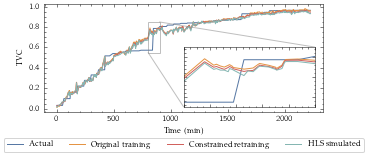

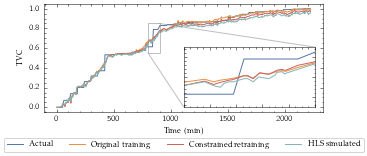

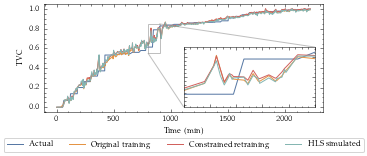

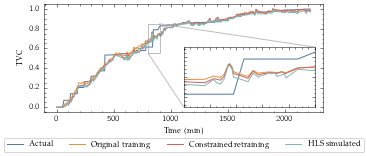

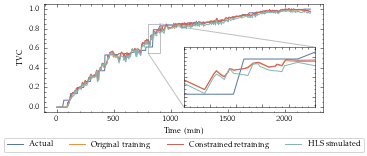

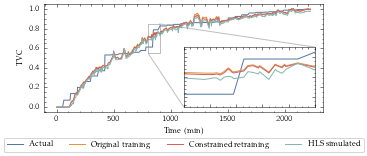

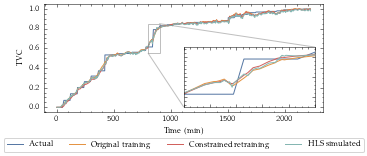

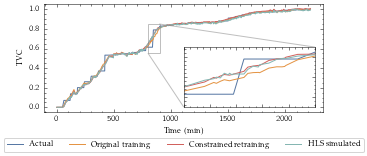

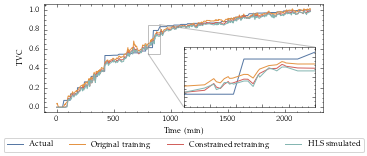

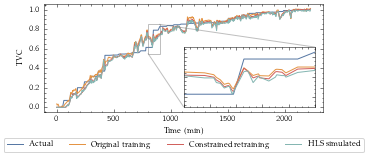

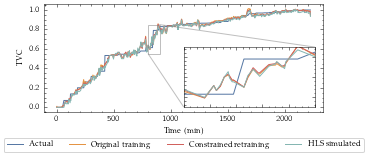

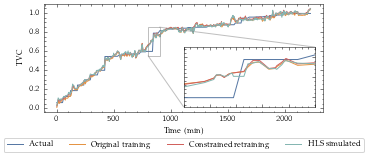

In [39]:
for i in range(12):

    fig, ax = plt.subplots(figsize=(15/3, 6/3))

    ax.plot(t[:, i], TVC[:, i], label='Actual')
    ax.plot(t[:, i], pred_TVC[:, i], label='Original training')
    ax.plot(t[:, i], pred_TVC_retrain[:, i], label='Constrained retraining')
    ax.plot(t[:, i], HLS_TVC[:, i], label='HLS simulated')
    # inset axes....
    axins = ax.inset_axes([0.5, 0.05, 0.47, 0.55])
    axins.plot(t[:, i], TVC[:, i])
    axins.plot(t[:, i], pred_TVC[:, i])
    axins.plot(t[:, i], pred_TVC_retrain[:, i])
    axins.plot(t[:, i], HLS_TVC[:, i])
    # sub region of the original image
    x1, x2, y1, y2 = 800, 900, 0.55, 0.85
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')

    ax.indicate_inset_zoom(axins, label='')

    ax.set_ylabel('TVC')
    ax.set_xlabel('Time (min)')

    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.2), ncol=4)

    plt.savefig('{}/quant/HLS-simulated.png'.format(cut_names[i]), dpi=600)

In [40]:
metrics.mean_squared_error(TVC, pred_TVC, multioutput='raw_values')

array([0.00225493, 0.0007515 , 0.00135672, 0.001176  , 0.001042  ,
       0.0022209 , 0.00043326, 0.00041842, 0.00095223, 0.00201492,
       0.00090557, 0.00087669])

In [41]:
metrics.mean_squared_error(TVC, pred_TVC_retrain, multioutput='raw_values')

array([0.00207195, 0.00085423, 0.00141884, 0.00115929, 0.00095931,
       0.00192771, 0.00043222, 0.00044467, 0.0010473 , 0.00203494,
       0.00078373, 0.00087589])

In [42]:
metrics.mean_squared_error(TVC, HLS_TVC, multioutput='raw_values')

array([0.00209282, 0.00161088, 0.00145316, 0.00134164, 0.00128531,
       0.00213988, 0.0004907 , 0.00048432, 0.00142899, 0.00231   ,
       0.00097556, 0.00097458])

### Classification tasks: HLS simulations after retraining

In [43]:
denorm_HLS_TVC = HLS_TVC*(TVC_max - TVC_min) + TVC_min

In [44]:
pred_labels_HLS = np.empty_like(labels)

for i in range(len(cut_names)):
    for j in range(denorm_HLS_TVC.shape[0]):
        if denorm_HLS_TVC[j,i] < 3:
            pred_labels_HLS[j,i] = 1
        elif 3<= denorm_HLS_TVC[j,i] <4:
            pred_labels_HLS[j,i] = 2
        elif 4<= denorm_HLS_TVC[j,i] <5:
            pred_labels_HLS[j,i] = 3
        else:
            pred_labels_HLS[j,i] = 4

In [45]:
pred_acc, pred_acc.mean()

(array([0.87162162, 0.95945946, 0.94594595, 0.96171171, 0.9527027 ,
        0.92567568, 0.96396396, 0.95945946, 0.94369369, 0.91216216,
        0.94369369, 0.90765766]),
 0.9373123123123124)

In [46]:
pred_retrain_acc, pred_retrain_acc.mean()

(array([0.87612613, 0.9481982 , 0.92117117, 0.96171171, 0.9481982 ,
        0.93693694, 0.93468468, 0.96396396, 0.94594595, 0.89414414,
        0.95495495, 0.94369369]),
 0.9358108108108109)

In [47]:
HLS_acc = np.array([metrics.accuracy_score(labels[:,i], pred_labels_HLS[:,i]) for i in range(12)])
HLS_acc, HLS_acc.mean()

(array([0.85135135, 0.94369369, 0.92342342, 0.9481982 , 0.93918919,
        0.92342342, 0.93918919, 0.96846847, 0.93468468, 0.89189189,
        0.93018018, 0.93243243]),
 0.927177177177177)

In [48]:
HLS_f1 = np.array([metrics.f1_score(labels[:,i], pred_labels_HLS[:,i], average='macro') for i in range(12)])
HLS_f1, HLS_f1.mean()

(array([0.85250422, 0.92431603, 0.88484617, 0.924356  , 0.91474708,
        0.91005191, 0.89288806, 0.94447978, 0.91177419, 0.87026005,
        0.90007334, 0.91311437]),
 0.9036175992466844)

#### HLS simulations before retraining ((10,2) data during the fixed-point selection)

In [49]:
HLS_TVC_noR = HLSpredTVC[:,9,:]

In [50]:
denorm_HLS_TVC_noR = HLS_TVC_noR*(TVC_max - TVC_min) + TVC_min

In [51]:
pred_labels_HLS_noR = np.empty_like(labels)

for i in range(len(cut_names)):
    for j in range(denorm_HLS_TVC_noR.shape[0]):
        if denorm_HLS_TVC_noR[j,i] < 3:
            pred_labels_HLS_noR[j,i] = 1
        elif 3<= denorm_HLS_TVC_noR[j,i] <4:
            pred_labels_HLS_noR[j,i] = 2
        elif 4<= denorm_HLS_TVC_noR[j,i] <5:
            pred_labels_HLS_noR[j,i] = 3
        else:
            pred_labels_HLS_noR[j,i] = 4

In [52]:
HLS_acc_noR = np.array([metrics.accuracy_score(labels[:,i], pred_labels_HLS_noR[:,i]) for i in range(12)])
HLS_acc_noR, HLS_acc_noR.mean()

(array([0.84684685, 0.93243243, 0.94144144, 0.97072072, 0.90540541,
        0.91891892, 0.93468468, 0.95495495, 0.94369369, 0.90315315,
        0.94144144, 0.90540541]),
 0.924924924924925)

In [53]:
HLS_f1_noR = np.array([metrics.f1_score(labels[:,i], pred_labels_HLS_noR[:,i], average='macro') for i in range(12)])
HLS_f1_noR, HLS_f1_noR.mean()

(array([0.85271719, 0.90315171, 0.91564333, 0.96165895, 0.88153451,
        0.91208171, 0.88674536, 0.92509806, 0.92011852, 0.89433135,
        0.91668229, 0.86953633]),
 0.9032749441637887)

## FPGA data
After testing the FPGA using the [fpga.ipynb](https://github.com/eneriz-daniel/MeatNet/blob/master/fpga.ipynb), its results can be evaluated.

In [54]:
try:
    mkdir('FPGA')
except FileExistsError:
    pass

params_names= ['w01', 'b01', 'w12', 'b12', 'w23', 'b23']

for i in range(12):
    try:
        mkdir('FPGA/{}'.format(cut_names[i]))
    except FileExistsError:
        pass

    np.savetxt('FPGA/{}/test.txt'.format(cut_names[i]), np.column_stack([t[:,i], TVC[:,i], pred_TVC[:,i], sens_smooth[:,:,i]]), header='Time(s) TVC(norm) PredTVC(norm) Smoothed sensor readings (11 channels)')
    
    j=0
    for name, param in quantmodel[i].named_parameters():
        exec(params_names[j]+"= param.detach().numpy()")
        j+=1
    np.savez("FPGA/{}/params-quant.npz".format(cut_names[i]), w01=w01, b01=b01, w12=w12, b12=b12, w23=w23, b23=b23)

In [55]:
FPGA_TVC = np.empty_like(TVC)

for i in range(12):
    FPGA_TVC[:,i] = np.load('FPGA/{}/FPGA-results.npz'.format(cut_names[i]))['TVCFPGA']

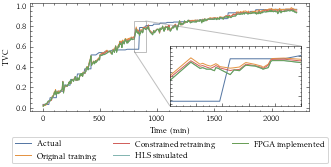

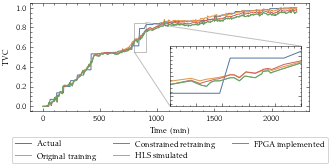

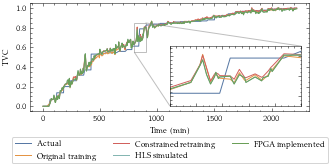

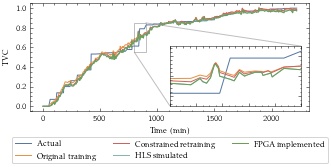

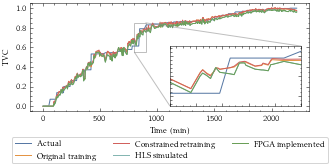

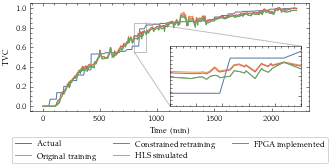

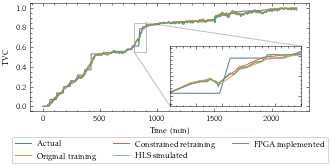

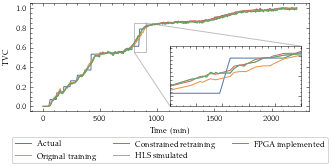

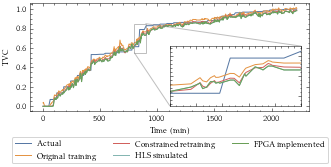

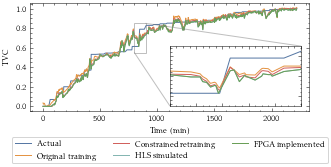

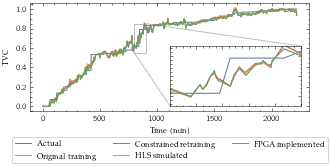

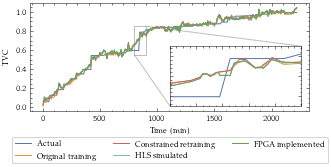

In [56]:
for i in range(12):
    
    fig, ax = plt.subplots(figsize=(15/3, 6/3))

    ax.plot(t[:, i], TVC[:, i], label='Actual')
    ax.plot(t[:, i], pred_TVC[:, i], label='Original training')
    ax.plot(t[:, i], pred_TVC_retrain[:, i], label='Constrained retraining')
    ax.plot(t[:, i], HLS_TVC[:, i], label='HLS simulated')
    ax.plot(t[:, i], FPGA_TVC[:, i], label='FPGA implemented')
    # inset axes....
    axins = ax.inset_axes([0.5, 0.05, 0.47, 0.55])
    axins.plot(t[:, i], TVC[:, i])
    axins.plot(t[:, i], pred_TVC[:, i])
    axins.plot(t[:, i], pred_TVC_retrain[:, i])
    axins.plot(t[:, i], HLS_TVC[:, i])
    axins.plot(t[:, i], FPGA_TVC[:, i])
    # sub region of the original image
    x1, x2, y1, y2 = 800, 900, 0.55, 0.85
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')

    ax.indicate_inset_zoom(axins, label='')

    ax.set_ylabel('TVC')
    ax.set_xlabel('Time (min)')

    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.2), ncol=3)

    plt.savefig('{}/quant/FPGA-implemented.png'.format(cut_names[i]), dpi=600)

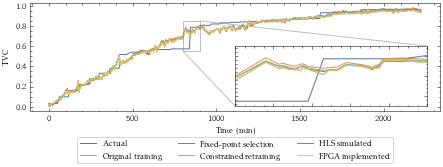

In [61]:
for i in range(1):
    
    fig, ax = plt.subplots(figsize=(22/3, 6/3))

    ax.plot(t[:, i], TVC[:, i], label='Actual')
    ax.plot(t[:, i], pred_TVC[:, i], label='Original training')
    ax.plot(t[:, i], HLS_TVC_noR[:, i], label='Fixed-point selection')
    ax.plot(t[:, i], pred_TVC_retrain[:, i], label='Constrained retraining')
    ax.plot(t[:, i], HLS_TVC[:, i], label='HLS simulated')
    ax.plot(t[:, i], FPGA_TVC[:, i], ':', label='FPGA implemented')
    # inset axes....
    axins = ax.inset_axes([0.5, 0.05, 0.47, 0.55])
    axins.plot(t[:, i], TVC[:, i])
    axins.plot(t[:, i], pred_TVC[:, i])
    axins.plot(t[:, i], HLS_TVC_noR[:, i])
    axins.plot(t[:, i], pred_TVC_retrain[:, i])
    axins.plot(t[:, i], HLS_TVC[:, i])
    axins.plot(t[:, i], FPGA_TVC[:, i], ':')
    # sub region of the original image
    x1, x2, y1, y2 = 800, 900, 0.55, 0.85
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    axins.set_yticklabels('')

    ax.indicate_inset_zoom(axins, label='')

    ax.set_ylabel('TVC')
    ax.set_xlabel('Time (min)')

    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.2), ncol=3)

    plt.savefig('IO-FPGA-implemented.png', dpi=600)

In [84]:
denorm_FPGA_TVC = FPGA_TVC*(TVC_max - TVC_min) + TVC_min

In [85]:
pred_labels_FPGA = np.empty_like(labels)

for i in range(len(cut_names)):
    for j in range(denorm_FPGA_TVC.shape[0]):
        if denorm_FPGA_TVC[j,i] < 3:
            pred_labels_FPGA[j,i] = 1
        elif 3<= denorm_FPGA_TVC[j,i] <4:
            pred_labels_FPGA[j,i] = 2
        elif 4<= denorm_FPGA_TVC[j,i] <5:
            pred_labels_FPGA[j,i] = 3
        else:
            pred_labels_FPGA[j,i] = 4

In [86]:
FPGA_acc = np.array([metrics.accuracy_score(labels[:,i], pred_labels_FPGA[:,i]) for i in range(12)])
FPGA_acc, FPGA_acc.mean()

(array([0.85135135, 0.94369369, 0.92342342, 0.9481982 , 0.93918919,
        0.92342342, 0.93918919, 0.96846847, 0.93468468, 0.89189189,
        0.93018018, 0.93243243]),
 0.927177177177177)

In [87]:
FPGA_f1 = np.array([metrics.f1_score(labels[:,i], pred_labels_FPGA[:,i], average='macro') for i in range(12)])
FPGA_f1, FPGA_f1.mean()

(array([0.85250422, 0.92431603, 0.88484617, 0.924356  , 0.91474708,
        0.91005191, 0.89288806, 0.94447978, 0.91177419, 0.87026005,
        0.90007334, 0.91311437]),
 0.9036175992466844)

## Reports

Here is the code to generate the comparation tables

In [88]:
class_report = pd.DataFrame([pred_acc, pred_f1, HLS_acc_noR, HLS_f1_noR, pred_retrain_acc, pred_retrain_f1, HLS_acc, HLS_f1, FPGA_acc, FPGA_f1], columns=cut_names)

In [89]:
pd.set_option('display.precision', 2)
class_report*100

Inside-Outside  Round  Top Sirloin  Tenderloin  Flap meat  Striploin  \
0           87.16  95.95        94.59       96.17      95.27      92.57   
1           87.10  94.65        92.11       94.72      93.12      89.83   
2           84.68  93.24        94.14       97.07      90.54      91.89   
3           85.27  90.32        91.56       96.17      88.15      91.21   
4           87.61  94.82        92.12       96.17      94.82      93.69   
5           87.92  92.71        87.47       94.44      92.04      91.31   
6           85.14  94.37        92.34       94.82      93.92      92.34   
7           85.25  92.43        88.48       92.44      91.47      91.01   
8           85.14  94.37        92.34       94.82      93.92      92.34   
9           85.25  92.43        88.48       92.44      91.47      91.01   

   Rib eye  Skirt meat  Brisket  Clod Chuck  Shin   Fat  
0    96.40       95.95    94.37       91.22 94.37 90.77  
1    93.75       92.87    91.77       89.47 91.90 86.99  
2    93.47       95.50    94.37       90.32 94.14 90.54  
3    88.67       92.51    92.01       89.43 91.67 86.95  
4    93.47       96.40    94.59       89.41 95.50 94.37  
5    88.51       93.79    92.46       86.83 93.01 91.76  
6    93.92       96.85    93.47       89.19 93.02 93.24  
7    89.29       94.45    91.18       87.03 90.01 91.31  
8    93.92       96.85    93.47       89.19 93.02 93.24  
9    89.29       94.45    91.18       87.03 90.01 91.31

In [90]:
class_report['Mean'] = [class_report.iloc[i].mean() for i in range(10)]

In [91]:
class_report*100

Inside-Outside  Round  Top Sirloin  Tenderloin  Flap meat  Striploin  \
0           87.16  95.95        94.59       96.17      95.27      92.57   
1           87.10  94.65        92.11       94.72      93.12      89.83   
2           84.68  93.24        94.14       97.07      90.54      91.89   
3           85.27  90.32        91.56       96.17      88.15      91.21   
4           87.61  94.82        92.12       96.17      94.82      93.69   
5           87.92  92.71        87.47       94.44      92.04      91.31   
6           85.14  94.37        92.34       94.82      93.92      92.34   
7           85.25  92.43        88.48       92.44      91.47      91.01   
8           85.14  94.37        92.34       94.82      93.92      92.34   
9           85.25  92.43        88.48       92.44      91.47      91.01   

   Rib eye  Skirt meat  Brisket  Clod Chuck  Shin   Fat  Mean  
0    96.40       95.95    94.37       91.22 94.37 90.77 93.73  
1    93.75       92.87    91.77       89.47 91.90 86.99 91.52  
2    93.47       95.50    94.37       90.32 94.14 90.54 92.49  
3    88.67       92.51    92.01       89.43 91.67 86.95 90.33  
4    93.47       96.40    94.59       89.41 95.50 94.37 93.58  
5    88.51       93.79    92.46       86.83 93.01 91.76 91.02  
6    93.92       96.85    93.47       89.19 93.02 93.24 92.72  
7    89.29       94.45    91.18       87.03 90.01 91.31 90.36  
8    93.92       96.85    93.47       89.19 93.02 93.24 92.72  
9    89.29       94.45    91.18       87.03 90.01 91.31 90.36

In [92]:
reg_report = pd.DataFrame([metrics.mean_squared_error(TVC, pred_TVC, multioutput='raw_values'),
                           metrics.mean_squared_error(TVC, HLS_TVC_noR, multioutput='raw_values'),
                           metrics.mean_squared_error(TVC, pred_TVC_retrain, multioutput='raw_values'),
                           metrics.mean_squared_error(TVC, HLS_TVC, multioutput='raw_values'),
                           metrics.mean_squared_error(TVC, FPGA_TVC, multioutput='raw_values')], columns=cut_names)

reg_report['Mean'] = [reg_report.iloc[i].mean() for i in range(5)]

reg_report

Inside-Outside  Round  Top Sirloin  Tenderloin  Flap meat  Striploin  \
0            0.00   0.00         0.00        0.00       0.00       0.00   
1            0.00   0.00         0.00        0.00       0.00       0.00   
2            0.00   0.00         0.00        0.00       0.00       0.00   
3            0.00   0.00         0.00        0.00       0.00       0.00   
4            0.00   0.00         0.00        0.00       0.00       0.00   

   Rib eye  Skirt meat  Brisket  Clod Chuck  Shin  Fat  Mean  
0     0.00        0.00     0.00        0.00  0.00 0.00  0.00  
1     0.00        0.00     0.00        0.00  0.00 0.00  0.00  
2     0.00        0.00     0.00        0.00  0.00 0.00  0.00  
3     0.00        0.00     0.00        0.00  0.00 0.00  0.00  
4     0.00        0.00     0.00        0.00  0.00 0.00  0.00

In [93]:
pd.options.display.float_format = '{:.2f}'.format

reg_report*1e3

Inside-Outside  Round  Top Sirloin  Tenderloin  Flap meat  Striploin  \
0            2.25   0.75         1.36        1.18       1.04       2.22   
1            2.33   0.96         1.41        1.18       1.45       2.51   
2            2.07   0.85         1.42        1.16       0.96       1.93   
3            2.09   1.61         1.45        1.34       1.29       2.14   
4            2.09   1.61         1.45        1.34       1.29       2.14   

   Rib eye  Skirt meat  Brisket  Clod Chuck  Shin  Fat  Mean  
0     0.43        0.42     0.95        2.01  0.91 0.88  1.20  
1     0.52        0.53     1.09        2.09  1.06 1.01  1.35  
2     0.43        0.44     1.05        2.03  0.78 0.88  1.17  
3     0.49        0.48     1.43        2.31  0.98 0.97  1.38  
4     0.49        0.48     1.43        2.31  0.98 0.97  1.38